In [ ]:
import matplotlib.pyplot as plt 
import numpy as np                                  
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import math
import torch.nn.functional as F

In [ ]:
def riemann(b_n,psy,x):
  dx=abs(x[-1])/len(x)
  projection=sum(b_n*psy*dx)
  return projection

In [ ]:
x = torch.unsqueeze(torch.linspace(0., 10., 100), dim=1)
x=Variable(x)

In [124]:
class UnperturbedNet(nn.Module):
    def __init__(self, D, H, C):
        super(TwoLayerNet, self).__init__()
        #torch.manual_seed(501)        
        self.fc1 = nn.Linear(D,H)
        self.fc = nn.Linear(H,H)
        self.fc2 = nn.Linear(H,C)

    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc(x)
      x = F.relu(x)
      x = self.fc2(x)
      return x

In [ ]:
def hamiltonian_loss(output,N,x):
  loss=0.0
  a=10.
  amplitude=0.0
  for n in range(1,N):
    H_nn=(math.pi**2)*(n**2)/(2*a**2)
    decomposition=riemann(math.sqrt(2./a)*torch.sin(n*x*math.pi/a),output,x)
    loss+=H_nn*abs(decomposition)**2
    amplitude+=abs(decomposition)**2
  loss=loss/(amplitude)
  return loss 

In [ ]:
def perturbed_loss(output,N,x):
  a=10.
  M=100
  N=100
  alpha = 2.
  decompositions=torch.zeros(M)
  x_nm=torch.zeros((N,M))
  for n in range(N):
    for m in range(M):
      decompositions[m]= riemann(math.sqrt(2./a)*torch.sin((m+1)*x*math.pi/a),output,x)
      if not m == n:
        x_nm[n][m] = (math.cos((n-m)*math.pi)-1)/(n-m)**2-(math.cos((n+m)*math.pi)-1)/(n+m)**2
        x_nm[n][m] = x_nm[n][m]*a/math.pi**2
      if m == n :
        x_nm[n][m] = a/2.
  x_loc = x_nm*decompositions
  loss = alpha*torch.sum((x_loc.sum(dim=1)*decompositions**2))/torch.sum(decompositions**3)
  loss = loss + hamiltonian_loss(output,N,x)
  return loss

In [ ]:
def train(model, criterion, optimizer, epochs,x, verbose=True):
  loss_history=[]
  for epoch in range(epochs):

    outputs = model(x)

    optimizer.zero_grad()
  
    loss = criterion(outputs, 100,x)
    
    loss.backward()
    
    optimizer.step()
    loss_history.append(loss.item())
    print(f'Epoch {epoch} / {epochs}: Approximated gs energy ',loss.item())
  return loss_history   

Epoch 0 / 1500: Approximated gs energy  314.7086181640625
Epoch 1 / 1500: Approximated gs energy  174.12850952148438
Epoch 2 / 1500: Approximated gs energy  133.2362060546875
Epoch 3 / 1500: Approximated gs energy  123.55281829833984
Epoch 4 / 1500: Approximated gs energy  117.4221420288086
Epoch 5 / 1500: Approximated gs energy  112.78673553466797
Epoch 6 / 1500: Approximated gs energy  108.8714828491211
Epoch 7 / 1500: Approximated gs energy  105.47799682617188
Epoch 8 / 1500: Approximated gs energy  102.48501586914062
Epoch 9 / 1500: Approximated gs energy  99.59364318847656
Epoch 10 / 1500: Approximated gs energy  96.76451110839844
Epoch 11 / 1500: Approximated gs energy  93.91301727294922
Epoch 12 / 1500: Approximated gs energy  90.97186279296875
Epoch 13 / 1500: Approximated gs energy  87.90076446533203
Epoch 14 / 1500: Approximated gs energy  84.59101867675781
Epoch 15 / 1500: Approximated gs energy  80.9840087890625
Epoch 16 / 1500: Approximated gs energy  76.86268615722656
Epo

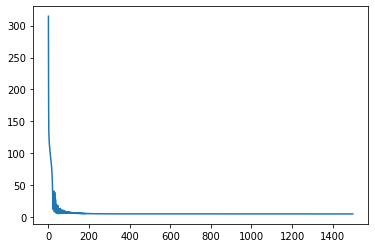

In [ ]:
import torch.optim as optim

D = 1
C = 1 
H = 1000
epochs=1500
learning_rate=6e-8
model = UnperturbedNet(D, H, C)

criterion = hamiltonian_loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_history=train(model,criterion,optimizer,epochs,x)
plt.plot(loss_history)
plt.show()

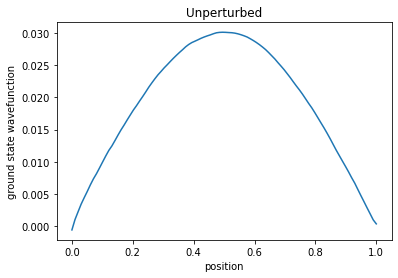

In [ ]:
model.eval()
predicted = model(x)
predicted = predicted.data.numpy()
plt.title("Unperturbed")
plt.xlabel("position")
plt.ylabel("ground state wavefunction")
plt.plot(x,predicted)
plt.show()

In [122]:
class PerturbedNet(nn.Module):
    def __init__(self, D, H1, H2):
        super(PerturbedNet, self).__init__()
        #torch.manual_seed(501)        
        self.fc1 = nn.Linear(D,H1)
        self.fc2 = nn.Linear(H1,H2)
        self.fc3 = nn.Linear(H2,1)

    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.fc3(x)
      return x

In [ ]:
D = 1
H1 = 500
H2 = 100
epochs=1000
learning_rate=3e-9
model = PerturbedNet(D, H1, H2)
criterion = perturbed_loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_history=train(model,criterion,optimizer,epochs,x)
plt.plot(loss_history)
plt.show()

In [ ]:
model.eval()
predicted = model(x)
predicted = predicted.data.numpy()
plt.plot(x,-predicted)
plt.title("Perturbed B")
plt.xlabel("position")
plt.ylabel("ground state wavefunction")
plt.show()